In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
from tqdm import tqdm
from dataclasses import dataclass

from interaction import potential, LocalSystem
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh
from mottmassey import mm_potential

plt.style.use('science')
ratio = 4/3
h = 3

In [2]:
INIT_CONDITIONS = np.array([0, 0.1])


def wave_function(v_r, energy, r_endpts=np.array([1e-4, 2000])):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-8, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol

In [3]:
P0 = np.array([-1.02155531e+01, -1.47988005e-01,  8.06190426e+01,  1.45657392e+03])

In [4]:
nR = 50
Rs = np.linspace(BETA4/4, BETA4/20, nR)

In [5]:
Ri = Rs[0]

In [6]:
s = LocalSystem(Ri)

In [7]:
gi = -1e-4
s.bound_state_spectrum(gi, 0)

array([-4.79543987e-05])

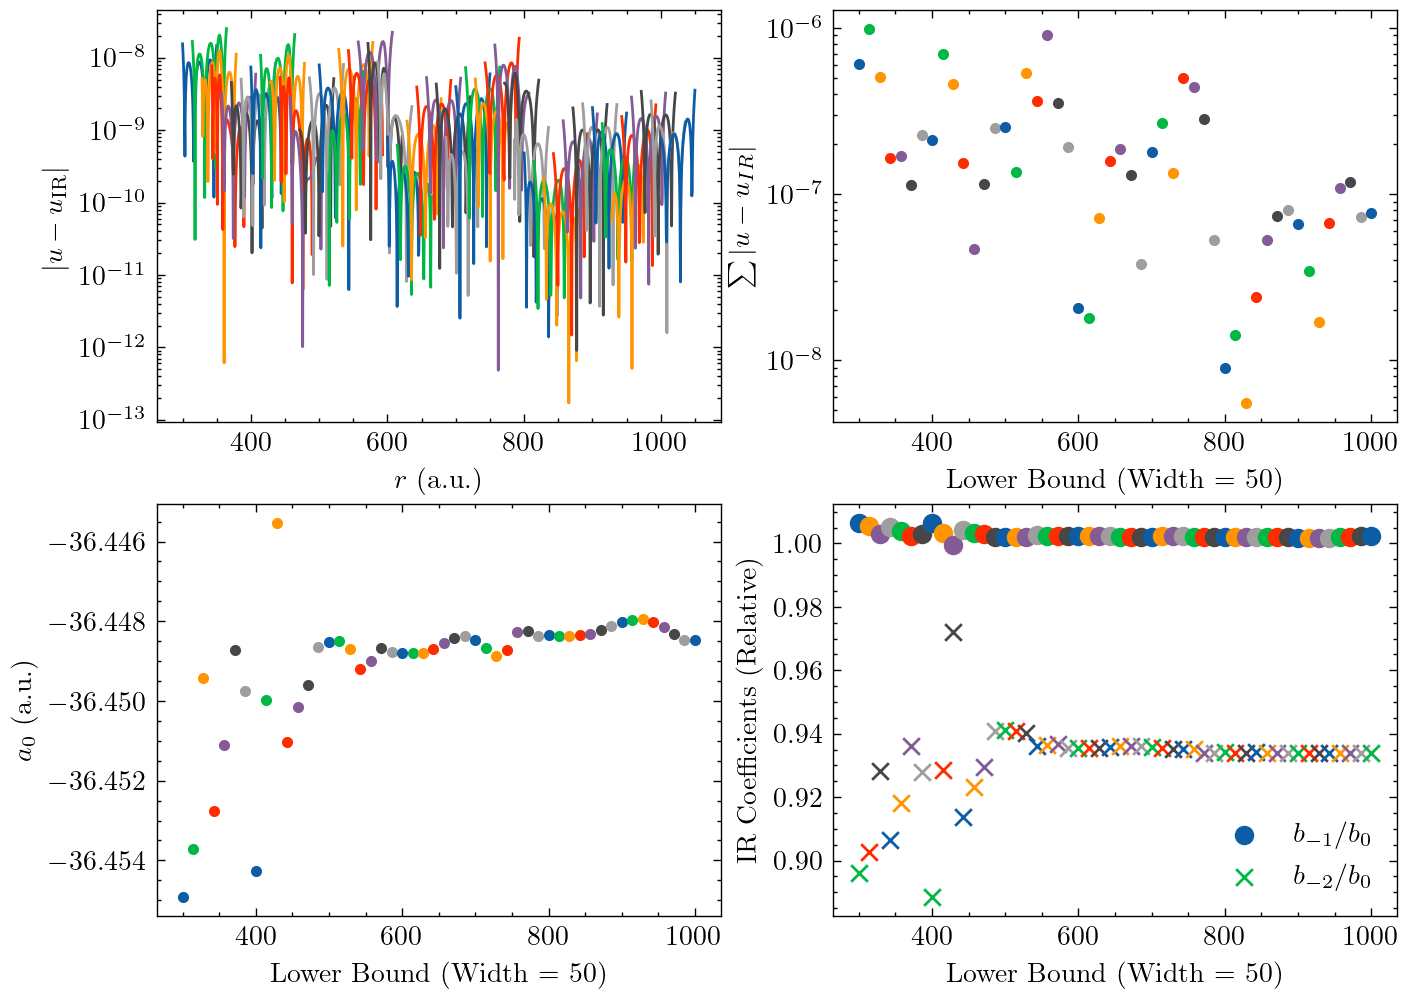

In [8]:
def u0_tail(r, b0, b1):
    return b0 + b1*r


def i4_tail(r, b0, b1, bm1, bm2):
    return b0 + b1*r + bm1/r + bm2/r**2


width = 50

pot = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)

lower_bounds = np.linspace(300, 1000, 50)

ir1_label = r'$b_{-1}/b_0$'
ir2_label = r'$b_{-2}/b_0$'

fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=200)
fig.patch.set_facecolor('white')

sol = wave_function(pot, 0, r_endpts=[1e-3, 2000])
guess = P0.copy()

for lb in lower_bounds:
    
    rs = np.linspace(lb, lb + width, 100)
    u = sol(rs)[0]

    pars, cov = optimize.curve_fit(i4_tail, rs, u, p0=guess)
    guess = pars

    b0, b1, bm1, bm2 = pars
    a0 = -b0/b1

    ir1 = bm1/b0
    ir1_pred = BETA4**2/(2*a0)
    
    ir2 = bm2/b0
    ir2_pred = -BETA4**2/6
    
    residuals = np.abs(u - i4_tail(rs, *pars))
    res_sum = np.sum(residuals)
    
    ax[0, 0].plot(rs, residuals)
    ax[0, 0].set_xlabel(rf'$r$ (a.u.)')
    ax[0, 0].set_ylabel(r'$|u - u_{\rm IR}|$')
    ax[0, 0].set_yscale('log')
    
    ax[0, 1].scatter(lb, res_sum, marker='.')
    ax[0, 1].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[0, 1].set_ylabel(r'$\sum|u - u_{IR}|$')
    ax[0, 1].set_yscale('log')
    
    ax[1, 0].scatter(lb, a0, marker='.')
    ax[1, 0].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[1, 0].set_ylabel(r'$a_0$ (a.u.)')
    
    ax[1, 1].scatter(lb, ir1/ir1_pred, marker='o', label=ir1_label)
    ax[1, 1].scatter(lb, ir2/ir2_pred, marker='x', label=ir2_label)
    ax[1, 1].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[1, 1].set_ylabel(r'IR Coefficients (Relative)')
    
    ir1_label = None
    ir2_label = None

ax[1, 1].legend();

In [9]:
A0_MM = -65
rs = np.linspace(700, 725, 100)

In [10]:
@dataclass
class Coefficients:
    '''
    Stores coefficients to IR-corrected, zero-energy, 1/r^4 wave function:
    u_{IR}(r) = b_0 + b_1 r + b_{-1} / r + b_{-2} / r^2
    '''
    b_0 : float
    b_1 : float
    b_m1 : float
    b_m2 : float
        
    def a_0(self):
        return -self.b_0 / self.b_1
    
    
    def b_m1_scaled(self):
        return self.b_m1 / self.b_0

    
    def b_m2_scaled(self):
        return self.b_m2 / self.b_0
    
    
    def b_m1_predicted(self):
        return BETA4**2/(2*self.a_0())
    
    
    def b_m2_predicted(self):
        return -BETA4**2/6
    

In [11]:
def extract_coefficients(pot, p0=P0.copy()):
    sol = wave_function(pot, 0, r_endpts=[1e-6, 1000])
    u = sol(rs)[0]
    pars, cov = optimize.curve_fit(i4_tail, rs, u, p0=p0)
    return pars


def extract_a0(pot, p0=P0.copy()):
    b0, b1, _, _ = extract_coefficients(pot, p0=p0)
    return -b0/b1


def diff(g, R, p0):
    pot = lambda r: potential(r, R) + g*local_LO_counterterm(r, R)
    a0 = extract_a0(pot, p0=p0)
    return (A0_MM - a0)/A0_MM

In [12]:
from scipy.interpolate import interp1d

In [13]:
c0 = optimize.fsolve(diff, gi, args=(Ri, guess))[0]

In [14]:
guess

array([-9.42748596e+00, -2.58652356e-01,  1.38682370e+02,  1.56995359e+03])

In [15]:
p0 = np.array([-9.42748596e+00, -2.58652356e-01,  1.38682370e+02,  1.56995359e+03])
guess = c0

In [16]:
results = []
coeffs = []

for i in tqdm(range(nR)):
    Ri = Rs[i]
    
    if i > 10:
        x = np.array(results)[-5:, 0]
        y = np.array(results)[-5:, 1]
        f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
        guess = f(Ri)
    
    c0 = optimize.fsolve(diff, guess, args=(Ri, p0))[0]
    
    pot = lambda r: potential(r, Ri) + c0*local_LO_counterterm(r, Ri)
    pars = extract_coefficients(pot, p0)
    p0 = pars
    
    coeffs.append(Coefficients(*pars))
    results.append([Ri, c0])

  8%|███▌                                        | 4/50 [00:00<00:05,  8.86it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 88%|█████████████████████████████████████▊     | 44/50 [00:09<00:02,  2.15it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 90%|██████████████████████████████████████▋    | 45/50 [00:10<00:03,  1.65it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/rk.py:582: RuntimeWarning: overflow encountered in multiply
  y *= x
 90%|██████████████████████████████████████▋    | 45/50 [00:

ValueError: array must not contain infs or NaNs

In [17]:
results = np.array(results)

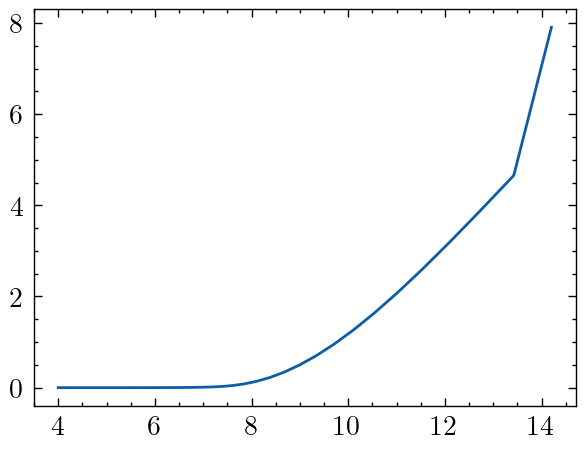

In [18]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/results[:, 0], results[:, 1])
# ax.plot(BETA4/rgf_lo[:, 0], rgf_lo[:, 1], linestyle='--')

# ax.set_ylim([-10, 1000])
# ax.set_yscale('log');

In [19]:
a0s = np.array([c.a_0() for c in coeffs])

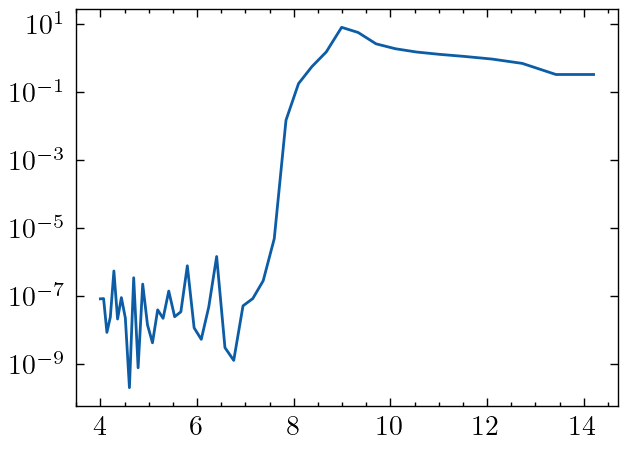

In [20]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/results[:, 0], np.abs((A0_MM - a0s)/A0_MM))
ax.set_yscale('log');
# ax.axhline(A0_MM, color='C1', linestyle='--');

In [21]:
ii = np.where(np.abs((A0_MM - a0s)/A0_MM) < 1e-6)[0]

In [22]:
ii

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28])

In [23]:
rgf = results[ii, :]

In [24]:
from free_solutions import phase_shift_interp

In [25]:
def wave_function(v_r, energy, r_endpts=np.array([1e-2, 2000])):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-9, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol


def delta(v_r, energy, r_match=300):
    k = np.sqrt(2*MU*energy)
    sol = wave_function(v_r, energy)
    
    delta_0 = np.random.rand()
    rel_diff = 1
    
    while rel_diff > 1e-5:
        r = np.linspace(0.99*r_match, 1.01*r_match, 100)
        rho = k*r
        u, _ = sol(r)
        delta_1 = phase_shift_interp(u, rho, 0, k*r_match).real
        
        rel_diff = np.abs((delta_1 - delta_0)/delta_0)
        delta_0 = delta_1
        r_match *= 1.1
    
    return delta_1, r_match/1.1

In [43]:
ks = np.linspace(1/BETA4, 50/BETA4, 100)
energies = ks**2/(2*MU)

In [45]:
index = 0
Ri, gi = rgf[index]
print(gi)
pot0 = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)

deltas0 = np.array([delta(pot0, en)[0] for en in energies])

-0.00013667818565696552


In [46]:
Ri

8.177473216915315

In [47]:
s0 = LocalSystem(Ri)

In [48]:
s0.bound_state_spectrum(gi, 0)

array([-6.04543161e-05])

In [49]:
rgf.shape

(28, 2)

In [50]:
index = 27
Ri, gi = rgf[index]
pot1 = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)

deltas1 = np.array([delta(pot1, en)[0] for en in energies])

In [51]:
s1 = LocalSystem(Ri)

In [52]:
s1.bound_state_spectrum(gi, 0)

array([-0.0001235])

/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_12216/1252340449.py:5: RuntimeWarning: invalid value encountered in remainder
  ax.plot(ks*BETA4, (deltas1 + np.pi) % np.pi)


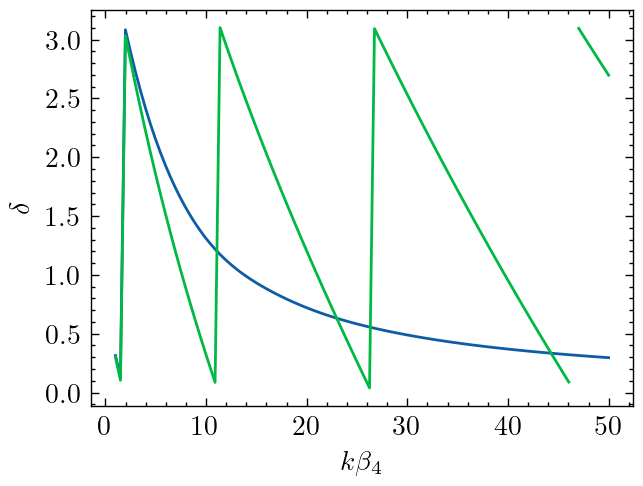

In [53]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(ks*BETA4, (deltas0 + np.pi) % np.pi)
ax.plot(ks*BETA4, (deltas1 + np.pi) % np.pi)

ax.set_xlabel(r'$k\beta_4$')
ax.set_ylabel(r'$\delta$');

In [54]:
BETA4 / rgf[[0, 27], 0]

array([4.        , 7.36842105])

In [55]:
rgf[[0, 27], 1]

array([-0.00013668,  0.02493599])

In [56]:
MU

237.7637980919727